In [1]:
import numpy as np
import math, random

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from geometry.model import Model, combine_observations, get_mesh
from geometry.utils.visualisation import illustrate_points, illustrate_mesh, illustrate_voxels
from geometry.voxel_grid import VoxelGrid

from rl.environment import Environment, CombiningObservationsWrapper
from rl.environment import StepPenaltyRewardWrapper, DepthMapWrapper
from rl.environment import VoxelGridWrapper, VoxelWrapper
from gym.wrappers import FrameStack, LazyFrames

from rl.dqn import CnnDQN, CnnDQNA, VoxelDQN
from rl.utils import DiskReplayBuffer


# !conda install -c conda-forge pyembree
# !conda install -c conda-forge igl
# !pip install Cython
# !pip install gym

In [2]:
def plot(frame_idx, rewards, novps, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('number of vp: %s' % np.mean(novps[-10:]))
    plt.plot(novps)
    plt.subplot(133)
    plt.title('loss')
    if len(losses) > 20:
        plt.plot(losses[20:])
    else:
        plt.plot(losses)
    plt.show()

## DQN

In [3]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    torch.cuda.set_device(1)
    print(torch.cuda.current_device())

1


In [4]:
import gym
from gym import spaces

class FrameStackWrapper(FrameStack):
    def __init__(self, env, num_stack, lz4_compress=False):
        super().__init__(env, num_stack, lz4_compress)

        low = np.concatenate(self.observation_space.low)
        high = np.concatenate(self.observation_space.high)
        self.observation_space = spaces.Box(low=low, high=high,
                                            dtype=self.observation_space.dtype)

#         shape = self.observation_space.shape
#         shape = shape[0] * shape[1], shape[2], shape[3]

#         self.observation_space = spaces.Box(0, 2, shape=shape,
#                                        dtype=self.observation_space.dtype)

    def _get_observation(self):
        assert len(self.frames) == self.num_stack, (len(self.frames), self.num_stack)
        observation = LazyFrames(list(self.frames), self.lz4_compress)
        return np.concatenate(observation)

    def reset(self, **kwargs):
        observation, action = self.env.reset(**kwargs)
        [self.frames.append(observation) for _ in range(self.num_stack)]
        return self._get_observation(), action

    def render(self, action, observation):
        self.env.render(action, observation)

    def final_reward(self):
        return self.env.final_reward()

In [5]:
env = Environment(illustrate=False, models_path="./data/1kabc/train/", number_of_view_points=100)
# env = CombiningObservationsWrapper(env)
# env = StepPenaltyRewardWrapper(env, weight=1.0)
# env = DepthMapWrapper(env)

env = VoxelGridWrapper(env)
env = CombiningObservationsWrapper(env)
env = VoxelWrapper(env)
env = StepPenaltyRewardWrapper(env)
env = FrameStackWrapper(env, num_stack=4, lz4_compress=False)

/opt/conda/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
from rl.dqn import CnnDQN, CnnDQNA

model = VoxelDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()

replay_initial = 1000
replay_buffer = DiskReplayBuffer(capacity=100000,
                                 overwrite=True,
                                 observation_dtype=env.observation_space.dtype,
                                 observation_shape=env.observation_space.shape)

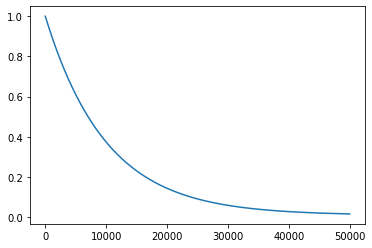

In [7]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 10000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * \
        math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(50000)])

### Training

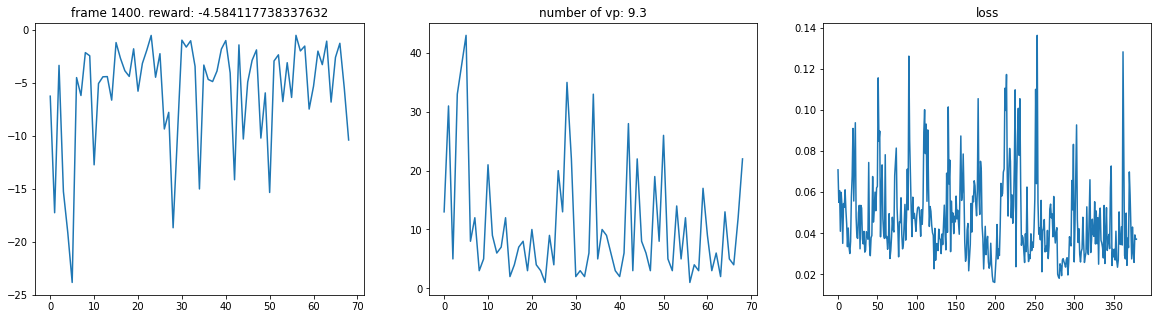

Action:  57
0.24481003874400045 0.4986367725905274 0.7434468113345278
Action:  43 (random)
0.25825478517319145 0.48983732445584827 0.7480921096290397
Action:  69 (random)
0.25261666570288555 0.49547544392615417 0.7480921096290397
Action:  53 (random)
0.24284392528768867 0.5053145457455583 0.7481584710332471
Action:  72 (random)
0.493202416918429 0.4816403503771685 0.9748427672955975
Frame:  1405 Number of View Points:  1

Action:  57
0.23161431854585973 0.15721201319948458 0.3888263317453443
Action:  86 (random)
0.3316038721359426 0.19494441716678584 0.5265482893027285
Action:  26 (random)
0.29148965805418203 0.2954310868570349 0.5869207449112169
Action:  66 (random)
0.3088829305661954 0.2944518463935274 0.6033347769597228
Action:  99 (random)
0.18655547043665993 0.41742893839833356 0.6039844088349935
Action:  15 (random)
0.33045476704505883 0.3716673637474921 0.7021221307925509
Action:  85 (random)
0.32275924507277665 0.3793628857197743 0.7021221307925509
Action:  25 (random)
0.293874

In [ ]:
num_frames = 100000
batch_size = 128
save_model_path = "./models/abc-vdqn-{}.pt"


losses = []
all_rewards = []
all_nofs = []
episode_reward = 0

state, _ = env.reset()
nof_vp = 0
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)

    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward
    nof_vp += 1

    # env.render(action, state)

    if done:
        # final_reward = env.final_reward()
        # print("Number of View Points: ", nof_vp, " Hausdorff reward: ", final_reward)
        print("Frame: ", frame_idx, "Number of View Points: ", nof_vp)
        print()

        state, _ = env.reset()
        all_rewards.append(episode_reward)
        all_nofs.append(nof_vp)
        episode_reward = 0
        nof_vp = 0
        
    elif nof_vp > 50:
        state, _ = env.reset()
        episode_reward = 0
        nof_vp = 0
        
    if len(replay_buffer) > replay_initial:
        batch = replay_buffer.sample(batch_size)
        loss = model.compute_td_loss(*batch)
        losses.append(loss.item())
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, all_nofs, losses)
        
    if frame_idx % 500 ==  0:
        torch.save(model, save_model_path.format(frame_idx))

In [ ]:
illustrate_voxels(state)

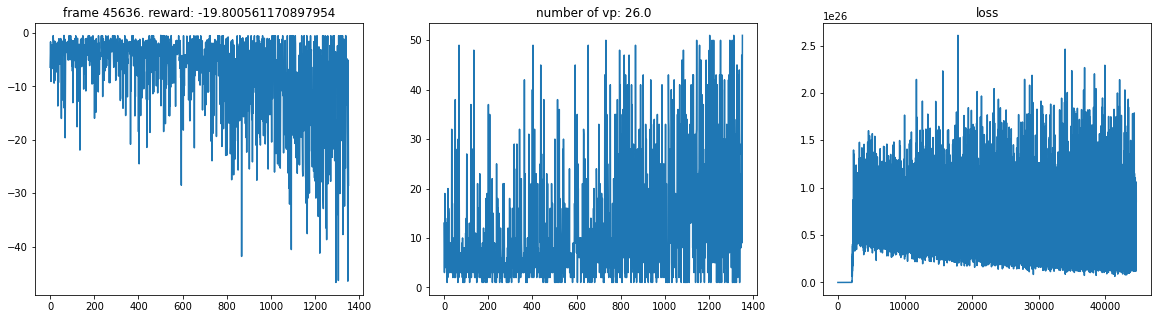

In [12]:
plot(frame_idx, all_rewards, all_nofs, losses)


In [13]:
def compute_metrics(env, agent_func, iter_cnt=10, max_iter=30):
    rewards, final_rewards, novp = [], [], []
    for _ in range(iter_cnt):
        state, action = env.reset()
        episode_reward = 0.0
        for t in range(max_iter):
            action = agent_func(state)
            state, reward, done, info = env.step(action)
            # print("REWARD: ", reward)
            env.render(action, state)
            episode_reward += reward

            if done:
                break

        final_reward = 0
        # final_reward = env.final_reward()
        # episode_reward += 1.0 / final_reward
        rewards.append(episode_reward)
        final_rewards.append(final_reward)
        novp.append(t + 1)
    return np.mean(rewards), np.mean(final_rewards), np.mean(novp)

In [ ]:
agent_func = lambda s : model.act(s, epsilon=0.0)
result = compute_metrics(env, agent_func)

Action:  60


/opt/conda/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60


In [60]:
print((6 * 256 * 256 * 8) / 1e9 * 3000, 'G')
print((10 * 512 * 512 * 8) / 1e9 * 5000, 'G')
print(1e6 * 10 * 512 * 512 * 4 / 2 ** 40, 'T')

9.437184 G
104.8576 G
9.5367431640625 T


In [ ]:
TODO Today:
    1. + check DQN with A, S as input -> send Sergey
    2. + Smaller depth_maps (6 * 256 * 256)
    3. + Illustrate reward as area + novp
    4. + Distributed Buffer
    5. + Buffer on hard disk (memmap)
    6. Floats to int
    7. GPU raycasting
    8. * Greedy algo
    9. * Voxels
    10. CNN different shapes input
    11. Preprocessed depth_maps
    
    10. Overfit experiments 
    11. ABC experiment
    
    12. Experiment radius = 1.0
    13. Experiments with smaller reward fine
    14. Experiment with different DQN-s
    15. ABC - write random model reading
    

Ideas:
    1. Add fine for same view_point
    
Big Experiments:
    1. Voxels
    2. PointNet
    3. Context (N first view_points)
    4. Meta-learning, подавать от простой к сложной детальке

In [15]:
difficult = [
    "00020107_b27a1602d1d44a3d89140ce4_007.obj",
    "00010095_5ae1ee45b583467fa009adc4_006.obj",
    "00010163_ccef4063b69f428e91b498c9_008.obj",
    "00010145_77759770d8cd48af80775d86_002.obj",
    "00010153_556de37e0a7447fcbfbdfd22_000.obj",
    "00010162_ccef4063b69f428e91b498c9_007.obj",
    "00020074_37170a1ba80747f1a1478985_000.obj",
    "00020077_bf146f0c5dee4199be920a21_000.obj",
    "00020080_7a689565e1e0481ca3ad4a6f_000.obj",
    "00010164_ccef4063b69f428e91b498c9_009.obj",
    "00010179_f91d806ac1e34ea1b14e23be_000.obj",
    "00020095_842a932142a9431784488344_000.obj",
    "00020097_e24ecc9c647f4bd1832bfb1d_000.obj",
    "00020106_b27a1602d1d44a3d89140ce4_006.obj",
    "00020141_b27a1602d1d44a3d89140ce4_041.obj",
    "00020155_b27a1602d1d44a3d89140ce4_055.obj",
    "00020186_b27a1602d1d44a3d89140ce4_086.obj",
    "00020202_b27a1602d1d44a3d89140ce4_102.obj",
    "00020203_b27a1602d1d44a3d89140ce4_103.obj",
    "00020213_1f65839d7f6c42bf8c2b3391_000.obj"]